# ADA Project - DataBrewers

The aim of this project is to analyze beer preference shifts across seasons and events, with a focus on understanding consumer trends in taste, aroma, palate, and appearance. By examining variation in ratings for beer style and alcohol content among US users, and comparing different states with varying weather conditions, we seek to identify seasonal trends. To deepen our understanding, we will conduct sentiment analysis to capture the tone of reviews and references to seasons, weather, or events, and correlate these insights with ratings. Our findings will provide actionable insights for professionals (brewers, marketers, etc.) by highlighting customer preferences throughout the year. Understanding these seasonal trends enables brewers to adjust product offerings to align more closely with consumer demand. As a conclusion of to our research, we could suggest the best beer that would be the perfect match for each season/festivity, in the form of a time fresco. 

## Data pre-processing 


In [1]:
import pandas as pd
import tarfile
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import re
import wordcloud
import nltk
import sys
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

The exploratory analysis is detailed in the notebook `data_cleaning.ipynb`. We decided to choose only the BeerAdvocate dataset, as it contains a sufficient number of user ratings and reviews. By analyzing the country of origin from the users, we discovered that most of the ratings were provided by users from the United States. Therefore, we restricted the dataset to include only American reviews.
 
 The complete processing and cleaning workflow is implemented in `src/scripts/preprocessing.py`. In this script, we begin by loading the raw data files for beers, reviews, users, breweries, and ratings. User location is split into country and state, and non-US users are filtered out. We then assign a US region (e.g. Northeast, Midwest) to each entry based on the user's state. Beer styles are simplified by removing country prefixes like "Belgian" or "American" and reclassified into broader categories using a style map. The script also categorizes beer based on their Alcohol By Volume (ABV) values, dividing them into three categories (low, medium, and high) using a quantile-based thresholds. We assign a season to each reviews based on the month it was published (e.g. Spring, Summer, Fall, Winter). The dataset is filtered to only include years with at least 70,000 reviews. Missing values in the rating column are handled by removing rows where ratings are missing. Finally, the cleaned versions of the datasets are saved as compressed `csv`files in the `data/cleaned/`directory. 

In [2]:
# Run the preprocessing script
# %run src/scripts/preprocessing.py

#### Loading the data

In [3]:
reviews = pd.read_csv('./data/cleaned/reviews.csv.gz', compression='gzip')
print("reviews loaded")
ratings = pd.read_csv('./data/cleaned/ratings.csv.gz', compression='gzip')
print("ratings loaded")
users = pd.read_csv('./data/cleaned/users.csv.gz', compression='gzip')
print("users loaded")
beers_ba = pd.read_csv('./data/cleaned/beers.csv.gz', compression='gzip')
print("beers loaded")
breweries_ba = pd.read_csv('./data/cleaned/breweries.csv.gz', compression='gzip')
print("breweries loaded")

reviews loaded
ratings loaded
users loaded
beers loaded
breweries loaded


## Semantic analysis

In [8]:
import src.scripts.semantic_analysis as sa

### Tokenisation
Here we tokenise and clean the reviews so we can use them later



In [9]:
clean_reviews = sa.get_cleaned_reviews(reviews)

100%|██████████| 2048878/2048878 [18:28<00:00, 1848.01it/s] 
c:\Users\marin\Documents\ma1\ada-2024-project-databrewers\src\scripts\semantic_analysis.py:34: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Occurences of Words
Here simply count the frequency of words appearing in our reviews here again we select just a few

In [ ]:
top_20_words,word_freq = sa.top_n_words(clean_reviews, 20)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Processing: 100%|██████████| 253627098/253627098 [04:54<00:00, 861384.83it/s] 


### General Wordcloud
We generate a simple wordcloud to get the idea our distribution

In [6]:
import src.scripts.semantic_analysis as sem
sem.gen_wordcloud(word_freq,Title="Top 20 words in reviews")

ModuleNotFoundError: No module named 'plotly'

With juste a glance we can see a lot of words around the taste and the aroma we know we can direct our analysis on those


### Sentiment Analysis of the reviews
We want to get an idea of the type of words used to describe certain negative of positive traits


Classifying words...


Word Classification Progress: 100%|██████████| 5000/5000 [00:00<00:00, 250083.71it/s]


Word classification completed.
Number of positive words among the top 5000 words: 419
Number of negative words among the top 5000 words: 256


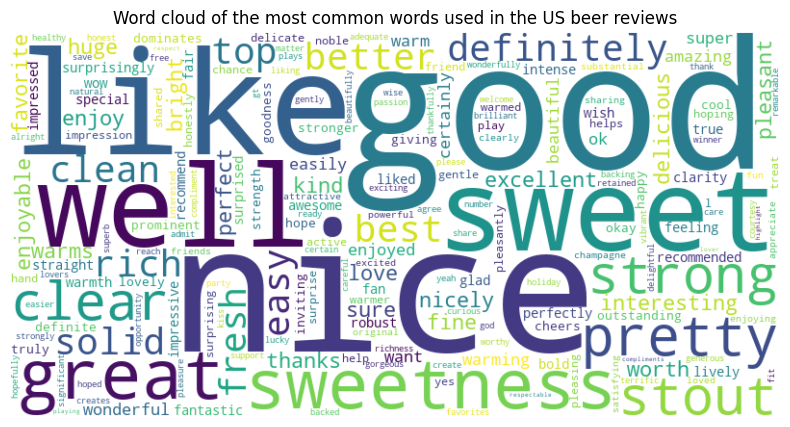

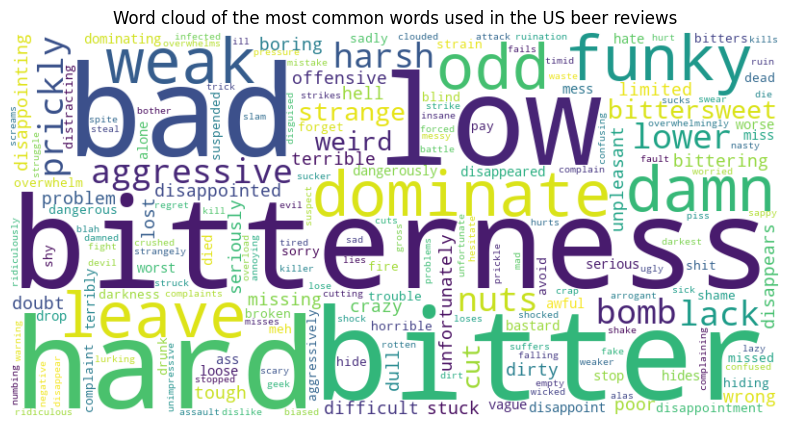

In [9]:
sa.sentiment_analysis(word_freq)

### Flavour Analysis
We want to count the occurences of certain "taste" related descriptive words for beers with a good grade, to see if can understand our tastes relative to the months


In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer

def process_flavours(text, flavours):
    """
    Process the 'cleaned_tokens' column to count occurrences of each flavour.
    
    Parameters:
    - text: pd.DataFrame containing the 'cleaned_tokens' column.
    - flavours: list of flavour strings to count.
    
    Returns:
    - pd.DataFrame with counts of each flavour.
    """
    # Initialize CountVectorizer with the specified flavours as the vocabulary
    vectorizer = CountVectorizer(vocabulary=flavours, binary=False)
    
    # If 'cleaned_tokens' are lists, join them into strings
    if text['cleaned_tokens'].dtype == 'object' and isinstance(text['cleaned_tokens'].iloc[0], list):
        text['cleaned_tokens'] = text['cleaned_tokens'].apply(lambda tokens: ' '.join(tokens))
    
    # Fit and transform the 'cleaned_tokens' to get counts
    counts = vectorizer.transform(text['cleaned_tokens'])
    
    # Convert the counts to a DataFrame
    counts_df = pd.DataFrame(counts.toarray(), columns=flavours, index=text.index)
    
    return counts_df

def analyse_flavours(reviews: pd.DataFrame):
    """
    Analyze flavour occurrences in beer reviews and plot normalized occurrences over time.
    
    Parameters:
    - reviews: pd.DataFrame containing beer reviews with columns ['aroma', 'palate', 'cleaned_tokens', 'month'].
    
    Returns:
    - pd.DataFrame with additional flavour count and normalization columns.
    """
    # Define all flavours
    all_flavours = ['hoppy', 'malty', 'fruity', 'spicy', 'citrus', 
                    'sweet', 'bitter', 'sour', 'tart', 'crisp']
    
    # Define primary and other flavours
    primary_flavours = ['citrus', 'sweet', 'bitter']
    other_flavours = [flavour for flavour in all_flavours if flavour not in primary_flavours]
    
    # Drop reviews rows with missing 'aroma' or 'palate' scores
    display(reviews.columns )
    reviews = reviews.dropna(subset=['aroma', 'palate'])
    display(reviews.columns )
    # Keep reviews where the sum of 'aroma' and 'palate' is >= 8 (i.e., average >= 4)
    reviews = reviews[(reviews['aroma'] + reviews['palate']) >= 8.0]
    display(reviews.columns )
    
    # Process all flavours using the optimized process_flavours function
    flavour_counts = process_flavours(reviews, all_flavours)
    display(reviews.columns )
    
    # Add flavour counts to the reviews DataFrame
    reviews = pd.concat([reviews, flavour_counts], axis=1)
    display(reviews.columns )
    
    # Keep only reviews where the sum of all flavour counts is > 0
    reviews = reviews[flavour_counts.sum(axis=1) > 0]
    display(reviews.columns )
    
    # This sums up all flavour counts for each month
    total_flavour_mentions_per_month = flavour_counts.groupby(reviews['month']).transform('sum').sum(axis=1)
    reviews['total_flavour_mentions'] = total_flavour_mentions_per_month
    
    print("Normalizing flavour occurrences by total flavour mentions per month...")
    
    # Normalize flavour counts by total_flavour_mentions
    normalized_columns = [f"{flavour}_normalized" for flavour in all_flavours]
    reviews[normalized_columns] = flavour_counts.div(reviews['total_flavour_mentions'], axis=0)
    
    print("Flavour occurrences normalized.")
    
    # Prepare data for plotting
    plot_data = reviews.melt(
        id_vars=['month'], 
        value_vars=normalized_columns,
        var_name='flavour', 
        value_name='normalized_occurrence'
    )
    
    # Clean the 'flavour' column by removing '_normalized'
    plot_data['flavour'] = plot_data['flavour'].str.replace('_normalized', '', regex=False)
    
    # Convert 'month' to datetime if it's not already
    if not pd.api.types.is_datetime64_any_dtype(plot_data['month']):
        plot_data['month'] = pd.to_datetime(plot_data['month'])
    
    # Sort by month for proper plotting
    plot_data = plot_data.sort_values('month')
    
    # Separate data into primary and other flavours
    primary_plot_data = plot_data[plot_data['flavour'].isin(primary_flavours)]
    other_plot_data = plot_data[plot_data['flavour'].isin(other_flavours)]
    
    # Set up the plotting environment with two subplots
    fig, axes = plt.subplots(1, 1, figsize=(15, 20), sharex=True)
    
    # Plot for Primary Flavours
    sns.lineplot(
        data=primary_plot_data, 
        x='month', 
        y='normalized_occurrence', 
        hue='flavour', 
        marker='o', 
        ax=axes[0]
    )
    axes[0].set_title('Normalized Occurrences of Citrus, Sweet, and Bitter Flavours Over Time')
    axes[0].set_xlabel('Month')
    axes[0].set_ylabel('Normalized Occurrences')
    axes[0].legend(title='Flavour')
    
    
    # Improve layout
    plt.tight_layout()
    plt.show()
    
    return reviews


,abv,appearance,aroma,beer_id,beer_name,brewery_id,brewery_name,date,overall,palate,...,country,states,region,style_simp,abv_category,year,month,day,season,cleaned_tokens
0,4.5,3.25,2.75,142544,Régab,37262,Societe des Brasseries du Gabon (SOBRAGA),2015-08-20 10:00:00,3.0,3.25,...,United States,Washington,West,Pale Lager,low,2015,8,20,Summer,"[from, a, bottle, pours, a, piss, yellow, colo..."


Index(['abv', 'appearance', 'aroma', 'beer_id', 'beer_name', 'brewery_id',
       'brewery_name', 'date', 'overall', 'palate', 'rating', 'style', 'taste',
       'text', 'user_id', 'user_name', 'location', 'country', 'states',
       'region', 'style_simp', 'abv_category', 'year', 'month', 'day',
       'season', 'cleaned_tokens'],
      dtype='object')

Index(['abv', 'appearance', 'aroma', 'beer_id', 'beer_name', 'brewery_id',
       'brewery_name', 'date', 'overall', 'palate', 'rating', 'style', 'taste',
       'text', 'user_id', 'user_name', 'location', 'country', 'states',
       'region', 'style_simp', 'abv_category', 'year', 'month', 'day',
       'season', 'cleaned_tokens'],
      dtype='object')

Index(['abv', 'appearance', 'aroma', 'beer_id', 'beer_name', 'brewery_id',
       'brewery_name', 'date', 'overall', 'palate', 'rating', 'style', 'taste',
       'text', 'user_id', 'user_name', 'location', 'country', 'states',
       'region', 'style_simp', 'abv_category', 'year', 'month', 'day',
       'season', 'cleaned_tokens'],
      dtype='object')

Index(['abv', 'appearance', 'aroma', 'beer_id', 'beer_name', 'brewery_id',
       'brewery_name', 'date', 'overall', 'palate', 'rating', 'style', 'taste',
       'text', 'user_id', 'user_name', 'location', 'country', 'states',
       'region', 'style_simp', 'abv_category', 'year', 'month', 'day',
       'season', 'cleaned_tokens'],
      dtype='object')

Index(['abv', 'appearance', 'aroma', 'beer_id', 'beer_name', 'brewery_id',
       'brewery_name', 'date', 'overall', 'palate', 'rating', 'style', 'taste',
       'text', 'user_id', 'user_name', 'location', 'country', 'states',
       'region', 'style_simp', 'abv_category', 'year', 'month', 'day',
       'season', 'cleaned_tokens', 'hoppy', 'malty', 'fruity', 'spicy',
       'citrus', 'sweet', 'bitter', 'sour', 'tart', 'crisp'],
      dtype='object')

Index(['abv', 'appearance', 'aroma', 'beer_id', 'beer_name', 'brewery_id',
       'brewery_name', 'date', 'overall', 'palate', 'rating', 'style', 'taste',
       'text', 'user_id', 'user_name', 'location', 'country', 'states',
       'region', 'style_simp', 'abv_category', 'year', 'month', 'day',
       'season', 'cleaned_tokens', 'hoppy', 'malty', 'fruity', 'spicy',
       'citrus', 'sweet', 'bitter', 'sour', 'tart', 'crisp'],
      dtype='object')

Normalizing flavour occurrences by total flavour mentions per month...
Flavour occurrences normalized.


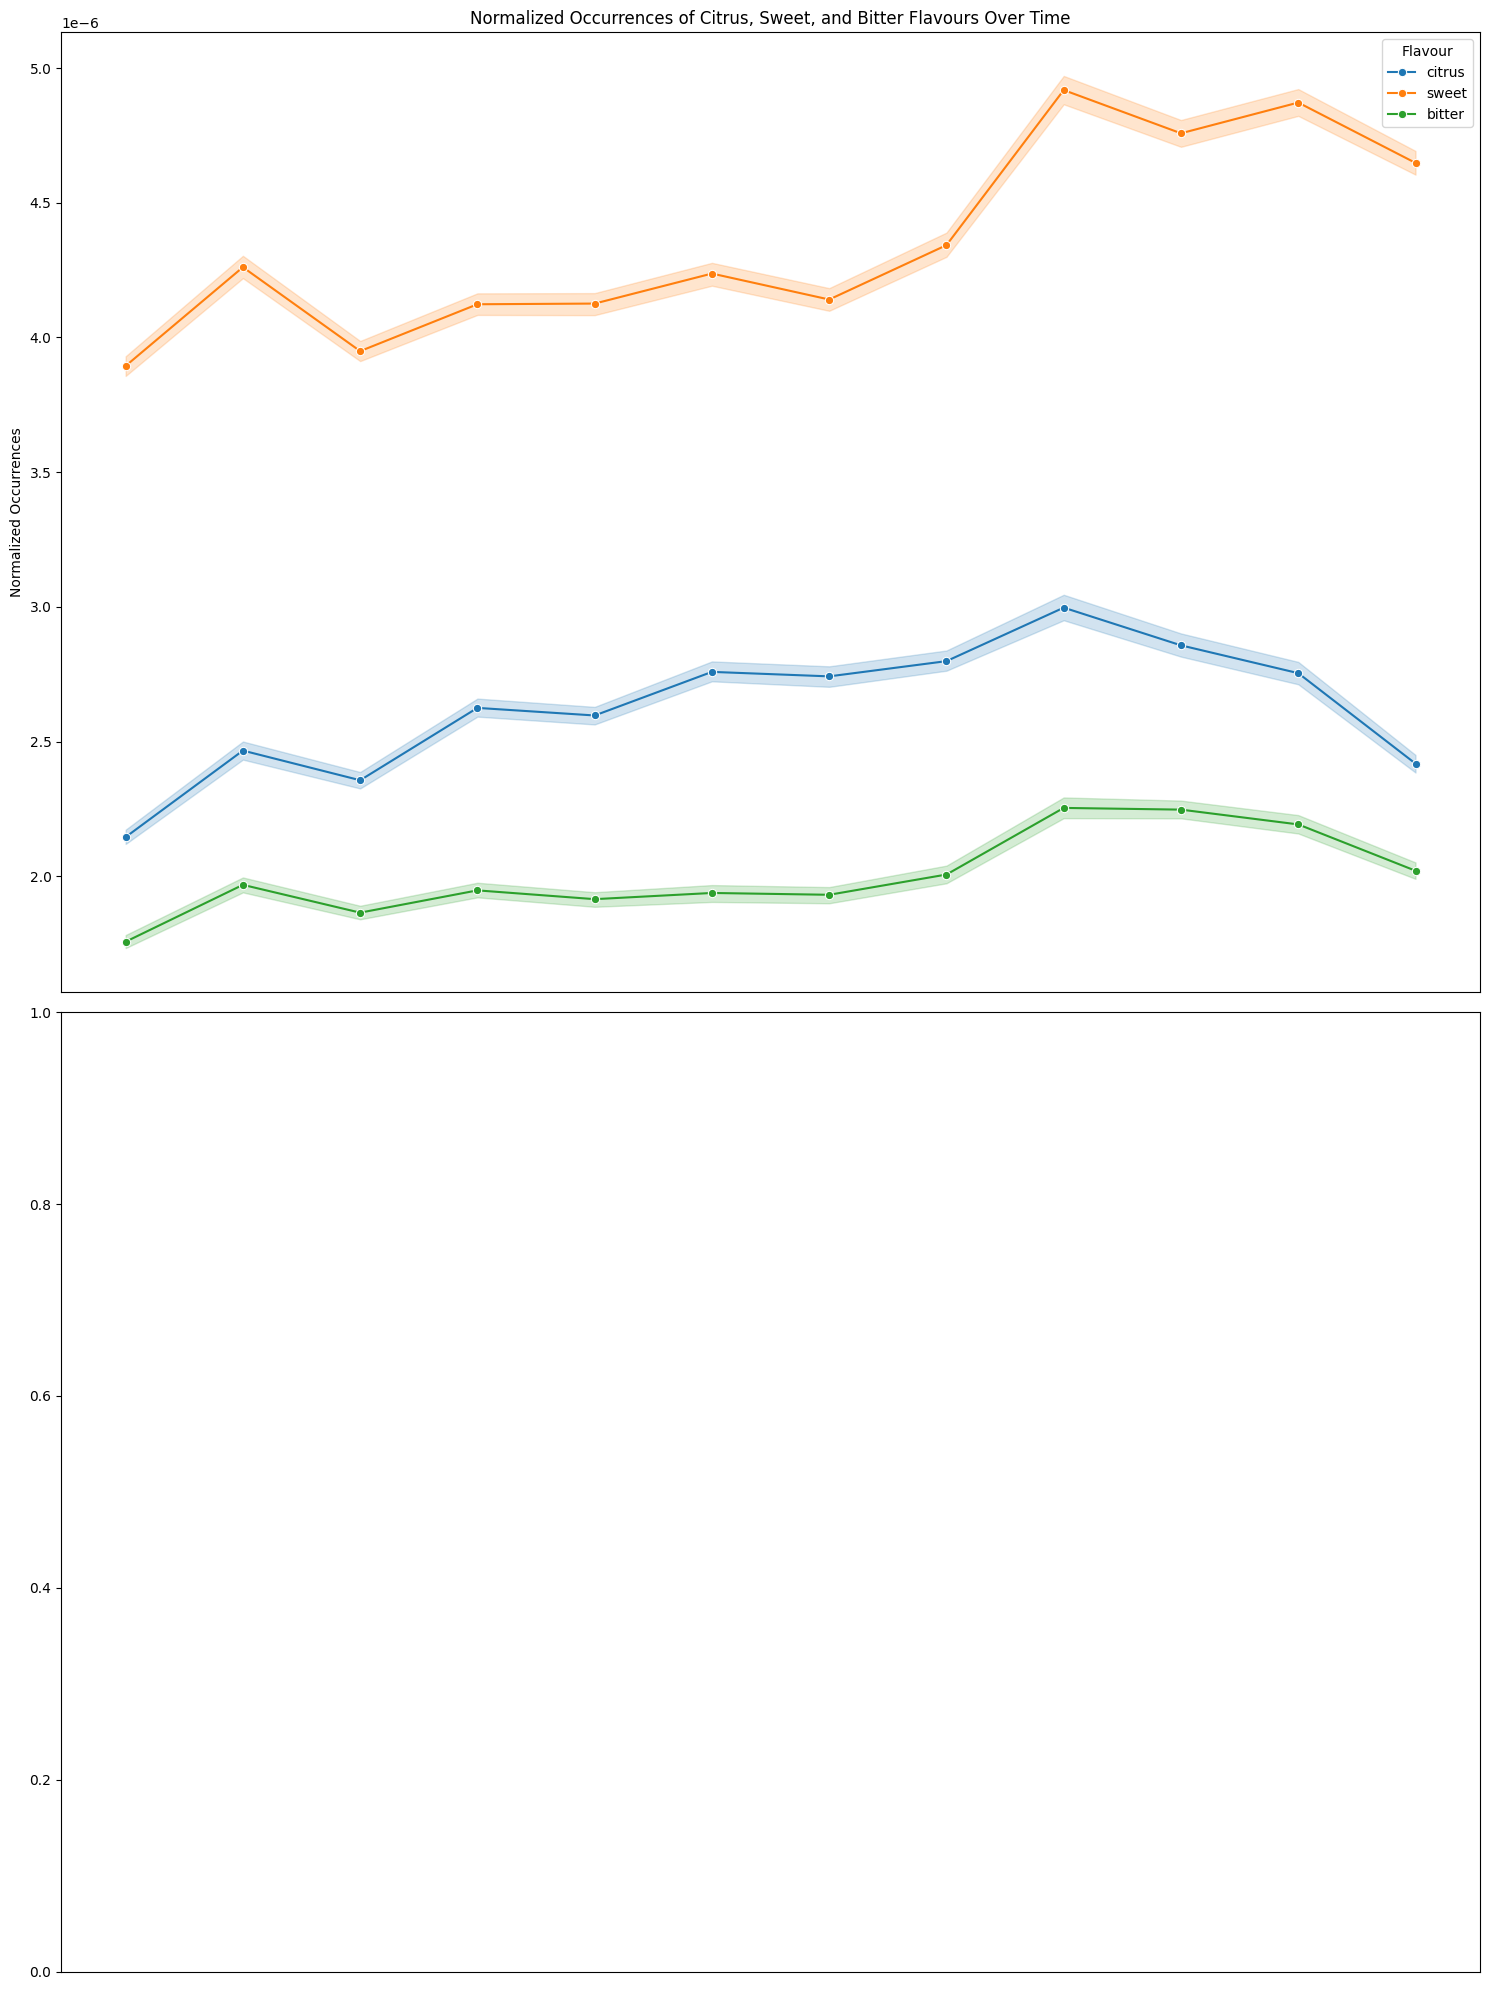

,abv,appearance,aroma,beer_id,beer_name,brewery_id,brewery_name,date,overall,palate,...,hoppy_normalized,malty_normalized,fruity_normalized,spicy_normalized,citrus_normalized,sweet_normalized,bitter_normalized,sour_normalized,tart_normalized,crisp_normalized
19,4.8,4.0,4.00,19827,Legbiter,10093,Strangford Lough Brewing Company Ltd,2011-05-16 10:00:00,4.0,4.5,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000006,0.0
38,4.8,4.0,3.50,19827,Legbiter,10093,Strangford Lough Brewing Company Ltd,2010-05-20 10:00:00,3.0,4.5,...,0.0,0.000006,0.0,0.000000,0.000000,0.000006,0.000000,0.0,0.000000,0.0
44,4.8,3.5,4.00,19827,Legbiter,10093,Strangford Lough Brewing Company Ltd,2010-04-10 10:00:00,4.5,4.0,...,0.0,0.000006,0.0,0.000000,0.000000,0.000023,0.000000,0.0,0.000000,0.0
46,4.8,4.0,4.00,19827,Legbiter,10093,Strangford Lough Brewing Company Ltd,2010-04-02 10:00:00,4.0,4.0,...,0.0,0.000000,0.0,0.000000,0.000006,0.000006,0.000006,0.0,0.000000,0.0
47,4.8,4.0,4.00,19827,Legbiter,10093,Strangford Lough Brewing Company Ltd,2010-04-01 10:00:00,3.0,4.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.000006,0.000000,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2048850,12.1,4.5,4.00,71104,Where There's Smoke,23640,Twisted Manzanita Ales,2011-07-17 10:00:00,4.5,4.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.000006,0.000000,0.0,0.000000,0.0
2048851,7.4,4.0,3.75,77211,Where There's Smoke,23640,Twisted Manzanita Ales,2014-12-11 11:00:00,4.0,4.5,...,0.0,0.000006,0.0,0.000018,0.000000,0.000000,0.000000,0.0,0.000000,0.0
2048853,7.4,4.0,4.50,77211,Where There's Smoke,23640,Twisted Manzanita Ales,2012-03-11 11:00:00,4.0,4.5,...,0.0,0.000000,0.0,0.000016,0.000000,0.000000,0.000000,0.0,0.000000,0.0
2048865,9.5,3.5,5.00,64097,Witch's Hair Pumpkin Ale,23640,Twisted Manzanita Ales,2012-10-24 10:00:00,4.0,4.5,...,0.0,0.000000,0.0,0.000007,0.000000,0.000007,0.000000,0.0,0.000000,0.0


In [ ]:
display(clean_reviews.head(1))
analyse_flavours(clean_reviews)

In [52]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def group_styles_by_flavours(reviews):
    """
    Groups beer reviews by style, normalizes flavour mentions, and plots the distribution.

    Parameters:
    - reviews (pd.DataFrame): DataFrame containing beer reviews with a 'style_simp' column 
      and flavour columns ['hoppy', 'malty', 'fruity', 'spicy', 'citrus', 
      'sweet', 'bitter', 'sour', 'tart', 'crisp'].

    Returns:
    - pd.DataFrame: DataFrame with normalized flavour percentages per style.
    """
    # Define the list of flavours
    flavours = ['hoppy', 'malty', 'fruity', 'spicy', 'citrus', 
                    'sweet', 'bitter', 'sour', 'tart', 'crisp']
    
    # Validate that all necessary columns are present
    missing_flavours = [flavour for flavour in flavours if flavour not in reviews.columns]
    if missing_flavours:
        raise ValueError(f"The following flavour columns are missing in the DataFrame: {missing_flavours}")
    
    # Group by 'style_simp' and sum the flavour counts
    style_flavours = reviews.groupby('style_simp')[flavours].sum()
    
    print("Calculating total flavour mentions per style...")
    
    
    # Calculate the total flavour mentions per style
    style_flavours['total_flavours'] = style_flavours.sum(axis=1)

    
    # Handle potential division by zero by replacing zeros with NaN
    style_flavours['total_flavours'].replace(0, pd.NA, inplace=True)
    
    # Normalize the flavour counts to get proportions (percentages)
    normalized_flavours = style_flavours[flavours].div(style_flavours['total_flavours'], axis=0) * 100
    
    # Drop styles with zero total flavours to avoid NaN values
    normalized_flavours.dropna(inplace=True)
    
    # Reset index to turn 'style_simp' back into a column for plotting
    normalized_flavours = normalized_flavours.reset_index()
    
    # Melt the DataFrame to long format for seaborn
    plot_data = normalized_flavours.melt(
        id_vars='style_simp', 
        value_vars=flavours, 
        var_name='Flavour', 
        value_name='Percentage'
    )
    
    # Initialize the matplotlib figure
    plt.figure(figsize=(18, 12))
    
    # Create a bar plot with 'style_simp' on the x-axis and 'Percentage' on the y-axis
    sns.barplot(
        data=plot_data, 
        x='style_simp', 
        y='Percentage', 
        hue='Flavour',
        palette='Set2'  # Choose a color palette for better distinction
    )
    
    # Set plot titles and labels
    plt.title('Normalized Flavour Occurrences in US Beer Reviews by Style', fontsize=16)
    plt.xlabel('Beer Style', fontsize=14)
    plt.ylabel('Percentage of Flavour Mentions (%)', fontsize=14)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right', fontsize=12)
    
    # Adjust legend
    plt.legend(title='Flavour', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
    
    # Improve layout to prevent clipping of labels and legend
    plt.tight_layout()
    
    # Display the plot
    plt.show()
    
    return normalized_flavours


We are grouping the main styles to their percieved flavours

In [ ]:

display(reviews.head())
group_styles_by_flavours(flavour_review)

,abv,appearance,aroma,beer_id,beer_name,brewery_id,brewery_name,date,overall,palate,...,location,country,states,region,style_simp,abv_category,year,month,day,season
0,4.5,3.25,2.75,142544,Régab,37262,Societe des Brasseries du Gabon (SOBRAGA),2015-08-20 10:00:00,3.00,3.25,...,"United States, Washington",United States,Washington,West,Pale Lager,low,2015,8,20,Summer
1,4.5,3.00,3.50,19590,Barelegs Brew,10093,Strangford Lough Brewing Company Ltd,2009-02-20 11:00:00,3.50,3.50,...,"United States, New York",United States,New York,Northeast,Pale Ale,low,2009,2,20,Winter
2,4.8,4.25,4.50,19827,Legbiter,10093,Strangford Lough Brewing Company Ltd,2013-02-13 11:00:00,3.75,3.25,...,"United States, North Carolina",United States,North Carolina,South,Pale Ale,low,2013,2,13,Winter
3,4.8,4.00,3.75,19827,Legbiter,10093,Strangford Lough Brewing Company Ltd,2013-01-09 11:00:00,3.75,3.50,...,"United States, New York",United States,New York,Northeast,Pale Ale,low,2013,1,9,Winter
4,4.8,3.00,3.50,19827,Legbiter,10093,Strangford Lough Brewing Company Ltd,2012-11-17 11:00:00,2.50,2.50,...,"United States, Illinois",United States,Illinois,Midwest,Pale Ale,low,2012,11,17,Fall


Calculating total flavour mentions per style...
style_simp
Adjunct Lager                  1243
Ale                            4217
Amber / Red Ale               50236
Amber / Red Lager              2954
Barleywine                    63503
Berliner Weissbier            16123
Bitter                         3898
Black & Tan                     537
Black Ale                     25718
Blonde Ale                     6995
Bock                          46186
Brown Ale                     34760
Dark Ale                      33184
Dark Lager                    12412
Dark Mild Ale                  1012
Dark Wheat Ale                  702
Dortmunder / Export Lager      2880
Fruit / Vegetable Beer        26423
Herbed / Spiced Beer           7116
Hybrid Beer                    8165
IPA                          571808
Kristalweizen                  1227
Lambic - Fruit                24567
Lambic - Unblended             2878
Low Alcohol Beer                 55
Milk / Sweet Stout            16479
Munic

C:\Users\marin\AppData\Local\Temp\ipykernel_40876\269828001.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  style_flavours['total_flavours'].replace(0, pd.NA, inplace=True)
